In [1]:
%reload_ext lab_black

In [2]:
import control
import math
import numpy as np
from matplotlib import pyplot as plt

# Select Switching Frequency, Current Ripple Magnitude, and Inductor Size

In [3]:
vin = 20  # 20 V input
vout = 5  # 5 V output
iout = 5  # 5 A output

fsw = 500e3  # 500 kHz (internal oscillator)
iripple = 0.3 * 5  # 30% of 5A per datasheet recommendation
dutycycle = vout / vin  # duty cycle
L = dutycycle * (vin - vout) / iripple / fsw  # inductor

In [4]:
print("Duty Cycle: {:0.1f} %".format(dutycycle * 100))
print("Ripple Current: {:0.2f} A".format(iripple))
print("Inductance: {:0.1f} uH".format(L * 1e6))

Duty Cycle: 25.0 %
Ripple Current: 1.50 A
Inductance: 5.0 uH


# Switch-Mode Regulator Transfer Function

Design a 20V to 5V/5A buck converter using the Diodes Incorporated [AP64500](https://www.diodes.com/assets/Datasheets/AP64500.pdf), an integrated synchronous buck converter. Resolving the transfer function from the feedback node to the control node to the output node will require parsing the datasheet and cross-referencing [Ridley Engineering's small-signal model for current-mode control](https://ridleyengineering.com/images/current_mode_book/CurrentModeControl.pdf).

In [5]:
# parameters from datasheet
vfb = 0.8  # 800 mV, feedback voltage
gm = 0.15e-3  # 15 mS, error amplifier transconductance
se = 1.87 * fsw  # 1.87 V/T, slope compensation (negative ramp)
rt = 0.089  # V/A, current sense gain

In [6]:
# formulas from Ridley Engineering
sf = iripple * rt * fsw / (1 - dutycycle)  # off-time slope
sn = iripple * rt * fsw / dutycycle  # on-time slope
alpha = (sf - se) / (sn + se)  # equation 3.3
ts = 1 / fsw
fmfi = (1 / rt) * control.tf(1 + alpha, [ts, 0])  # equation 3.13
qz = -2 / math.pi  # equation 4.4
wn = math.pi / ts  # equation 4.5
he = 1 + control.tf([1, 0], wn * qz) + control.tf([1, 0, 0], wn ** 2)  # equation 4.3
iLvC = fmfi / (1 + fmfi * rt * he)  # equation 3.14

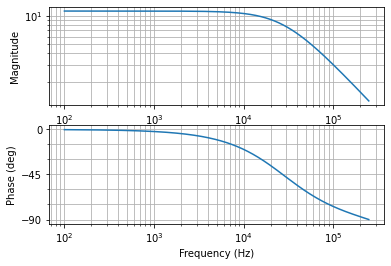

In [7]:
# control voltage to inductor current transfer function
mag, phase, omega = control.bode_plot(iLvC, omega_limits=(100, fsw / 2), Hz=True)

# Output Capacitance Impedance

In [8]:
def tantcap(c, esr):
    return control.tf(1, [c, 0]) + esr

In [9]:
cap10u = tantcap(10e-6, 6)  # TAJA106*004#NJ
cap47u = tantcap(47e-6, 2.6)  # TAJA476*004#NJ
cap100u = tantcap(100e-6, 1.4)  # TAJA107*004#NJ

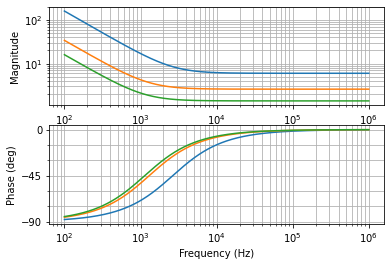

In [10]:
mag, phase, omega = control.bode_plot(cap10u, omega_limits=(100, 1e6), Hz=True)
mag, phase, omega = control.bode_plot(cap47u, omega_limits=(100, 1e6), Hz=True)
mag, phase, omega = control.bode_plot(cap100u, omega_limits=(100, 1e6), Hz=True)

# Signal Injection Transformer

A true signal injection transformer with flat amplitude over a wideband is expensive (more expensive than it should be; it's just a big ferrite core packaged in a nice box). There are a number of blogs which discuss repurposing transformers intended for other applications as a cheaper alternative ([Maxim Integrated](https://www.maximintegrated.com/en/design/technical-documents/app-notes/3/3245.html), [Electronic Projects for Fun](https://electronicprojectsforfun.wordpress.com/injection-transformers/)).

The following image is from [Mini-Circuits application note AN20-001](https://www.minicircuits.com/app/AN20-001.pdf). It shows the lumped parasitic model of a transformer. The following analysis only considers the magnetizing inductance (Lp) and primary winding resistance (R1), as these are the only parasitic values provided on the [PE-51687NL](https://www.digikey.com/en/products/detail/pulse-electronics-power/PE-51687NL/2266077?s=N4IgTCBcDaIAoFEC0BWAjANgBwHYByAMiALoC%2BQA) datasheet.

<img src="images/transformer_parasitic_model.png">

Note that for this signal injection application, the current sense transformer will be used in the reverse direction. The datasheet's "secondary" will be our "primary".

In [11]:
Lp = 20e-3  # primary magnetizing inductance
R1 = 1.4  # primary winding resistance
n = 10 / 100  # 100-turn primary, 10-turn secondary
Rsrc = 25  #  primary drive, 50 Ohm series with 50 Ohm in shunt
Rload = 22  # secondary burden

In [12]:
tf_Lp = control.tf([Lp, 0], 1)  # s-domain, s * Lp
Rload_xfmr = Rload / n ** 2  # primary reflected burden
tf_Lp_Rload_xfmr = tf_Lp * Rload_xfmr / (tf_Lp + Rload_xfmr)  # tf_Lp // Rload_xfmr
xfmr_vp = tf_Lp_Rload_xfmr / (Rsrc + R1 + tf_Lp_Rload_xfmr)  # primary winding voltage
xfmr_vs = xfmr_vp * n  # secondary winding voltage

In [13]:
cutoff_frq = -control.pole(xfmr_vs)[1] / math.tau
dcgain = control.dcgain(xfmr_vs)
wbgain = np.abs(control.evalfr(xfmr_vs, 100 * cutoff_frq * math.tau))

print("DC Gain: {:0.2f} V/V".format(dcgain))
print("Wideband Gain: {:0.2f} V/V".format(wbgain))
print("Cutoff Frequency: {:0.0f} Hz".format(cutoff_frq))

DC Gain: 0.00 V/V
Wideband Gain: 0.10 V/V
Cutoff Frequency: 208 Hz


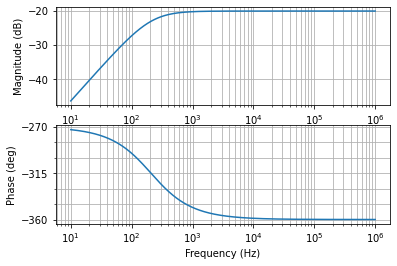

In [14]:
mag, phase, omega = control.bode_plot(xfmr_vs, omega_limits=(10, 1e6), Hz=True, dB=True)

In [15]:
vt_limit = 100 * 600e-6 / n  # volt-time product, bipolar
frq_limit = cutoff_frq / 100  # arbitrary
vt_gain = control.evalfr(xfmr_vp, frq_limit * math.tau) / frq_limit
vsrc_limit = np.abs(vt_limit / vt_gain / 2)  # square half-wave

print("Vsrc Limit (Volt-Time Product): {:0.1f} V".format(vsrc_limit))
# conclusion: transformer would overheat long before core saturation

Vsrc Limit (Volt-Time Product): 63.7 V
